In [1]:
import os

from PIL import Image
import skimage.io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def psnr(original, decoded):
    mse = np.mean(np.power(original - decoded, 2))
    if(mse == 0):
        return np.inf
    max_val = 255.0
    psnr = 20 * np.log10(max_val / np.sqrt(mse))
    return psnr

In [3]:
model_name = "default"

my_coords = {}
jpg_coords = {}

filenames = ["lena", "baboon", "peppers"]

for filename in filenames:
    my_coords[filename] = []
    for B in [1, 2, 4, 6]:
        image_path = fr"compression-lab-imgs\{filename}.png"
        encode_output_path = fr"compression-lab-imgs\{filename}_B{B}.neural"
        compressor_state_path = fr"compression-lab-imgs\{filename}_B{B}_state.json"
        decode_output_path = fr"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"

        orig_img_np = skimage.io.imread(image_path)
        n_pixels = np.prod(orig_img_np.shape)

        !python encode.py -i {image_path} -B {B} -s {compressor_state_path} -o {encode_output_path} -m {model_name}
        !python decode.py -i {encode_output_path} -B {B} -s {compressor_state_path} -o {decode_output_path}  -m {model_name}

        my_img_np = skimage.io.imread(decode_output_path)
        my_psnr = psnr(orig_img_np, my_img_np)
        my_bpp = os.path.getsize(encode_output_path) / n_pixels
        my_coords[filename].append((my_bpp, my_psnr))


    jpg_coords[filename] = []
    orig_img = Image.fromarray(orig_img_np)    
    for jpg_quality in [30, 60, 70, 90]:
        jpg_path = fr"compression-lab-imgs\{filename}_q{jpg_quality}.jpg"
        orig_img.save(jpg_path, "JPEG", quality=jpg_quality, optimize=True, progressive=True)
        
        jpg_np = skimage.io.imread(jpg_path)
        jpg_psnr = psnr(orig_img_np, jpg_np)
        jpg_bpp = os.path.getsize(jpg_path) / n_pixels
        jpg_coords[filename].append((jpg_bpp, jpg_psnr))

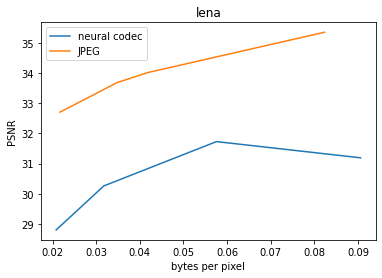

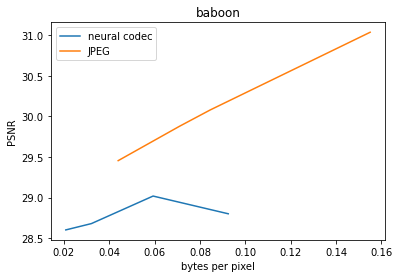

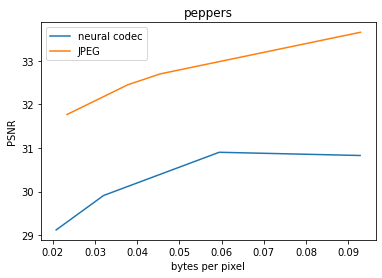

In [4]:
for filename in filenames:
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_title(filename)
    ax.set_xlabel('bytes per pixel')
    ax.set_ylabel('PSNR')
    plt.plot(*list(zip(*my_coords[filename])))
    plt.plot(*list(zip(*jpg_coords[filename])))
    ax.legend(["neural codec", "JPEG"])
    plt.show()

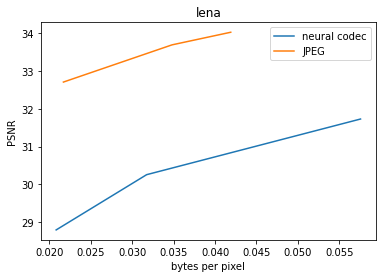

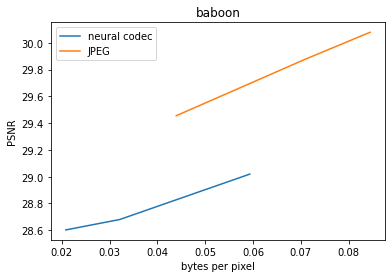

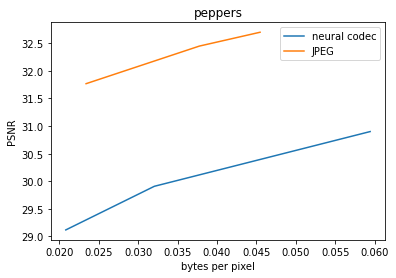

In [6]:
for filename in filenames:
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_title(filename)
    ax.set_xlabel('bytes per pixel')
    ax.set_ylabel('PSNR')
    plt.plot(*list(zip(*my_coords[filename][:-1])))
    plt.plot(*list(zip(*jpg_coords[filename][:-1])))
    ax.legend(["neural codec", "JPEG"])
    plt.show()

In [7]:
my_coords

{'lena': [(0.020834604899088543, 28.79890548374327),
  (0.031750996907552086, 30.25865024894468),
  (0.057558695475260414, 31.72911995424066),
  (0.0905621846516927, 31.191632994998404)],
 'baboon': [(0.020834604899088543, 28.602333959892107),
  (0.0321197509765625, 28.680209998030747),
  (0.059313456217447914, 29.019365209286402),
  (0.09244537353515625, 28.801168112600443)],
 'peppers': [(0.020834604899088543, 29.118912167270608),
  (0.0320587158203125, 29.909068406984794),
  (0.05941899617513021, 30.90066280799302),
  (0.0927747090657552, 30.826884333906207)]}

In [8]:
jpg_coords

{'lena': [(0.021709442138671875, 32.705530811829455),
  (0.03481419881184896, 33.68852107075787),
  (0.04189936319986979, 34.021802165263736),
  (0.08231226603190105, 35.35724122997543)],
 'baboon': [(0.043932596842447914, 29.455621963208543),
  (0.0709698994954427, 29.878943603825533),
  (0.08447647094726562, 30.07954585711434),
  (0.15500640869140625, 31.036887679752997)],
 'peppers': [(0.023408253987630207, 31.76813141238712),
  (0.037762959798177086, 32.448936817064464),
  (0.04546356201171875, 32.69988326299634),
  (0.09286880493164062, 33.65550539396375)]}

In [17]:
import os

from PIL import Image
import skimage.io
import numpy as np
import matplotlib.pyplot as plt

from looseless_compressors import Huffman 

from decoder_pipeline import decoder_pipeline
from trained_models import get_decoder

from encoder_pipeline import encoder_pipeline
from trained_models import get_encoder


In [35]:
"""
Quantization, no noize
"""
model_name = "default"

filename = 'lena'
B = 2

image_path = fr"compression-lab-imgs\{filename}.png"
encode_output_path = fr"compression-lab-imgs\{filename}_B{B}.neural"
compressor_state_path = fr"compression-lab-imgs\{filename}_B{B}_state.json"
decode_output_path = fr"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"

orig_img_np = skimage.io.imread(image_path)
n_pixels = np.prod(orig_img_np.shape)
looseless_compressor = Huffman()

encoder = get_encoder(model_name, B)
encoder_out, encoded = encoder_pipeline(
    encoder, image_path, B, compressor_state_path,
    encode_output_path, looseless_compressor)

decoder = get_decoder(model_name, B)
decoder.eval()
np_decoded_img = decoder_pipeline(
    decoder, encode_output_path, B, compressor_state_path,
    decode_output_path, looseless_compressor)

my_img_np = skimage.io.imread(decode_output_path)
my_psnr = psnr(orig_img_np, my_img_np)
my_bpp = os.path.getsize(encode_output_path) / n_pixels
# my_coords[filename].append((my_bpp, my_psnr))

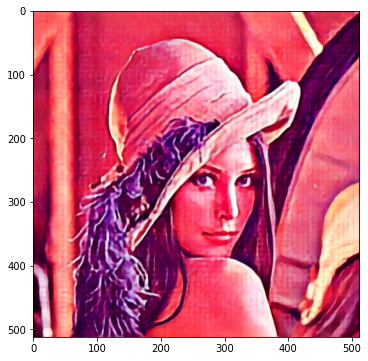

In [36]:
plt.figure(figsize=(6,6))
plt.imshow(np_decoded_img)

In [37]:
from typing import List
import os

import torch
import numpy as np
from PIL import Image

from trained_models import get_decoder
from looseless_compressors import LooselessCompressor, Huffman


def denormalize(img: torch.Tensor, means: List[int], stds: List[int]):
    result = torch.zeros_like(img)
    for i, (chan, mean, std) in enumerate(zip(img, means, stds)):
        result[i] = chan * std + mean
    return result

def denormalize_imagenet(img: torch.Tensor):
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    return denormalize(img, imagenet_mean, imagenet_std)


def decode_binary_file(filename):
    with open(filename, 'rb') as f:
        binary_data = f.read()
    str_with_padding = ''.join(
        format(byte, '08b') for byte in binary_data)
    pad_end = str_with_padding.rfind('1')
    return str_with_padding[:pad_end]

In [39]:
"""
QUANTIZATION, NO NOISE
"""

model_name = "default"

filename = 'lena'
B = 2

image_path = fr"compression-lab-imgs\{filename}.png"
encode_output_path = fr"compression-lab-imgs\{filename}_B{B}.neural"
compressor_state_path = fr"compression-lab-imgs\{filename}_B{B}_state.json"
decode_output_path = fr"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"

orig_img_np = skimage.io.imread(image_path)
n_pixels = np.prod(orig_img_np.shape)
looseless_compressor = Huffman()

encoder = get_encoder(model_name, B)
encoder_out, encoded = encoder_pipeline(
    encoder, image_path, B, compressor_state_path,
    encode_output_path, looseless_compressor)

decoder = get_decoder(model_name, B)

llc = looseless_compressor
    
decoder.eval()

binary_string = decode_binary_file(encode_output_path)
llc.init_from_file(compressor_state_path)
quantized = torch.tensor(llc.decode(binary_string))
encoder_output_flat = quantized / 2**B
height = width = int((len(encoder_output_flat)/decoder.in_channels)**0.5)

encoder_output = encoder_output_flat.reshape(
    1, decoder.in_channels, height, width)

decoded_tensor_imagenet_norm = decoder(encoder_output.type(torch.float32))

decoded_tensor = denormalize_imagenet(
    decoded_tensor_imagenet_norm.squeeze(0))

np_decoded_img = decoded_tensor.cpu().detach().numpy().transpose(1,2,0)
np_decoded_img = np.clip(np_decoded_img, 0, 1)
np_decoded_img = (np_decoded_img*255).astype(np.uint8)
pil_img = Image.fromarray(np_decoded_img, 'RGB')
pil_img.save(decode_output_path, "BMP")

my_img_np = skimage.io.imread(decode_output_path)
my_psnr = psnr(orig_img_np, my_img_np)
my_bpp = os.path.getsize(encode_output_path) / n_pixels
# my_coords[filename].append((my_bpp, my_psnr))

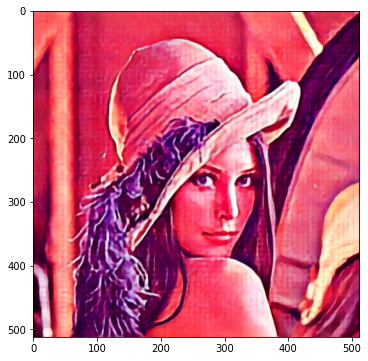

In [40]:
plt.figure(figsize=(6,6))
plt.imshow(np_decoded_img)

In [41]:
"""
NO QUANTIZATION, NOISE
"""

model_name = "default"

filename = 'lena'
B = 2

image_path = fr"compression-lab-imgs\{filename}.png"
encode_output_path = fr"compression-lab-imgs\{filename}_B{B}.neural"
compressor_state_path = fr"compression-lab-imgs\{filename}_B{B}_state.json"
decode_output_path = fr"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"

orig_img_np = skimage.io.imread(image_path)
n_pixels = np.prod(orig_img_np.shape)
looseless_compressor = Huffman()

encoder = get_encoder(model_name, B)
encoder_out, encoded = encoder_pipeline(
    encoder, image_path, B, compressor_state_path,
    encode_output_path, looseless_compressor)

decoder = get_decoder(model_name, B)

llc = looseless_compressor
    
decoder.eval()
shape = encoder_out.shape
mean = torch.full(shape, -0.5)
std = torch.full(shape, 0.5)
quan_err = 0.5**B * torch.normal(mean = mean, std = std)

decoded_tensor_imagenet_norm = decoder(encoder_out + quan_err)

decoded_tensor = denormalize_imagenet(
    decoded_tensor_imagenet_norm.squeeze(0))

np_decoded_img = decoded_tensor.cpu().detach().numpy().transpose(1,2,0)
np_decoded_img = np.clip(np_decoded_img, 0, 1)
np_decoded_img = (np_decoded_img*255).astype(np.uint8)
pil_img = Image.fromarray(np_decoded_img, 'RGB')
pil_img.save(decode_output_path, "BMP")

my_img_np = skimage.io.imread(decode_output_path)
my_psnr = psnr(orig_img_np, my_img_np)
my_bpp = os.path.getsize(encode_output_path) / n_pixels
# my_coords[filename].append((my_bpp, my_psnr))

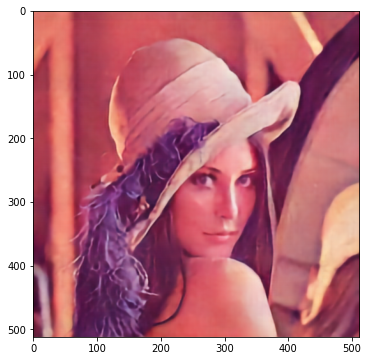

In [42]:
plt.figure(figsize=(6,6))
plt.imshow(np_decoded_img)

In [43]:
"""
NO QUANTIZATION, NO NOISE
"""

model_name = "default"

filename = 'lena'
B = 2

image_path = fr"compression-lab-imgs\{filename}.png"
encode_output_path = fr"compression-lab-imgs\{filename}_B{B}.neural"
compressor_state_path = fr"compression-lab-imgs\{filename}_B{B}_state.json"
decode_output_path = fr"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"

orig_img_np = skimage.io.imread(image_path)
n_pixels = np.prod(orig_img_np.shape)
looseless_compressor = Huffman()

encoder = get_encoder(model_name, B)
encoder_out, encoded = encoder_pipeline(
    encoder, image_path, B, compressor_state_path,
    encode_output_path, looseless_compressor)

decoder = get_decoder(model_name, B)

llc = looseless_compressor
    
decoder.eval()


decoded_tensor_imagenet_norm = decoder(encoder_out)

decoded_tensor = denormalize_imagenet(
    decoded_tensor_imagenet_norm.squeeze(0))

np_decoded_img = decoded_tensor.cpu().detach().numpy().transpose(1,2,0)
np_decoded_img = np.clip(np_decoded_img, 0, 1)
np_decoded_img = (np_decoded_img*255).astype(np.uint8)
pil_img = Image.fromarray(np_decoded_img, 'RGB')
pil_img.save(decode_output_path, "BMP")

my_img_np = skimage.io.imread(decode_output_path)
my_psnr = psnr(orig_img_np, my_img_np)
my_bpp = os.path.getsize(encode_output_path) / n_pixels
# my_coords[filename].append((my_bpp, my_psnr))

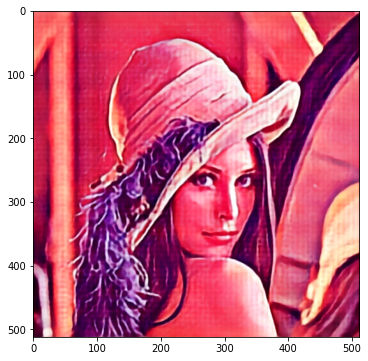

In [44]:
plt.figure(figsize=(6,6))
plt.imshow(np_decoded_img)

In [45]:
"""
QUANTIZATION, NOISE
"""

model_name = "default"

filename = 'lena'
B = 2

image_path = fr"compression-lab-imgs\{filename}.png"
encode_output_path = fr"compression-lab-imgs\{filename}_B{B}.neural"
compressor_state_path = fr"compression-lab-imgs\{filename}_B{B}_state.json"
decode_output_path = fr"compression-lab-imgs\{filename}_decoder_output_B{B}.bmp"

orig_img_np = skimage.io.imread(image_path)
n_pixels = np.prod(orig_img_np.shape)
looseless_compressor = Huffman()

encoder = get_encoder(model_name, B)
encoder_out, encoded = encoder_pipeline(
    encoder, image_path, B, compressor_state_path,
    encode_output_path, looseless_compressor)

decoder = get_decoder(model_name, B)

llc = looseless_compressor
    
decoder.eval()

binary_string = decode_binary_file(encode_output_path)
llc.init_from_file(compressor_state_path)
quantized = torch.tensor(llc.decode(binary_string))
encoder_output_flat = quantized / 2**B
height = width = int((len(encoder_output_flat)/decoder.in_channels)**0.5)

encoder_output = encoder_output_flat.reshape(
    1, decoder.in_channels, height, width)

shape = encoder_out.shape
mean = torch.full(shape, -0.5)
std = torch.full(shape, 0.5)
quan_err = 0.5**B * torch.normal(mean = mean, std = std)

decoded_tensor_imagenet_norm = decoder(encoder_output.type(torch.float32) + quan_err)

decoded_tensor = denormalize_imagenet(
    decoded_tensor_imagenet_norm.squeeze(0))

np_decoded_img = decoded_tensor.cpu().detach().numpy().transpose(1,2,0)
np_decoded_img = np.clip(np_decoded_img, 0, 1)
np_decoded_img = (np_decoded_img*255).astype(np.uint8)
pil_img = Image.fromarray(np_decoded_img, 'RGB')
pil_img.save(decode_output_path, "BMP")

my_img_np = skimage.io.imread(decode_output_path)
my_psnr = psnr(orig_img_np, my_img_np)
my_bpp = os.path.getsize(encode_output_path) / n_pixels
# my_coords[filename].append((my_bpp, my_psnr))

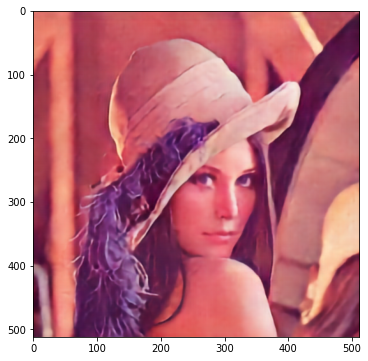

In [46]:
plt.figure(figsize=(6,6))
plt.imshow(np_decoded_img)